In [1]:
from icecube import dataio, icetray
import pandas as pd

In [2]:
GCD_PATH = "/project/6008051/pone_simulation/GCD_Library/PONE_800mGrid.i3.gz"

In [3]:
gcd = dataio.I3File(GCD_PATH)

In [4]:
g_frame = gcd.pop_frame(icetray.I3Frame.Geometry)

In [5]:
i3geo = g_frame["I3Geometry"]

In [6]:
omgeo = i3geo.omgeo

In [7]:
print("Number of OM entries in omgeo:", len(omgeo))
# 340*20*16

Number of OM entries in omgeo: 108800


In [8]:
for i, (om_key, om) in enumerate(omgeo.items()):
    if i >= 5:
        break
    print(
        om_key,
        "pos=", (om.position.x, om.position.y, om.position.z),
        "orient=", (om.orientation.x, om.orientation.y, om.orientation.z),
        "omtype=", om.omtype,
        "area=", om.area,
    )

OMKey(1,1,1) pos= (-120.0, -730.717967697245, -450.0) orient= (0.0, 0.0, -1.0) omtype= mDOM area= 0.5857538458367074
OMKey(1,1,2) pos= (-120.0, -730.717967697245, -450.0) orient= (0.0, 0.0, -1.0) omtype= mDOM area= 0.5857538458367074
OMKey(1,1,3) pos= (-120.0, -730.717967697245, -450.0) orient= (0.0, 0.0, -1.0) omtype= mDOM area= 0.5857538458367074
OMKey(1,1,4) pos= (-120.0, -730.717967697245, -450.0) orient= (0.0, 0.0, -1.0) omtype= mDOM area= 0.5857538458367074
OMKey(1,1,5) pos= (-120.0, -730.717967697245, -450.0) orient= (0.0, 0.0, -1.0) omtype= mDOM area= 0.5857538458367074


In [9]:
# what is area here?
# I know that DOMRadius=0.21590m

In [10]:
import math

area_from_gcd = 0.585753845836707
R = 0.21590  # m

surface_area = 4 * math.pi * R**2
cross_section = math.pi * R**2

print("area_from_gcd      =", area_from_gcd)
print("4*pi*R^2 (surface) =", surface_area)
print("pi*R^2 (cross-sec) =", cross_section)



area_from_gcd      = 0.585753845836707
4*pi*R^2 (surface) = 0.5857538458367074
pi*R^2 (cross-sec) = 0.14643846145917686


In [11]:
# g_frame["I3Geometry"].omgeo.area is the surface area of the DOM 

In [12]:
rows = []

for omkey, om in omgeo.items():
    pos = om.position
    ori = om.orientation  # has .dir/.up/.right (each has x,y,z)

    rows.append({
        "string": omkey.string,
        "om": omkey.om,
        "pmt": omkey.pmt,

        "x": pos.x,
        "y": pos.y,
        "z": pos.z,

        "dir_x": ori.dir.x,
        "dir_y": ori.dir.y,
        "dir_z": ori.dir.z,

        "up_x": ori.up.x,
        "up_y": ori.up.y,
        "up_z": ori.up.z,

        "right_x": ori.right.x,
        "right_y": ori.right.y,
        "right_z": ori.right.z,
    })

df_omgeo = pd.DataFrame(rows)
print(df_omgeo.shape)
df_omgeo.head()


(108800, 15)


,string,om,pmt,x,y,z,dir_x,dir_y,dir_z,up_x,up_y,up_z,right_x,right_y,right_z
0,1,1,1,-120.0,-730.717968,-450.0,1.224647e-16,0.0,-1.0,1.0,0.0,6.123234e-17,6.123234e-17,-1.0,6.123234e-17
1,1,1,2,-120.0,-730.717968,-450.0,1.224647e-16,0.0,-1.0,1.0,0.0,6.123234e-17,6.123234e-17,-1.0,6.123234e-17
2,1,1,3,-120.0,-730.717968,-450.0,1.224647e-16,0.0,-1.0,1.0,0.0,6.123234e-17,6.123234e-17,-1.0,6.123234e-17
3,1,1,4,-120.0,-730.717968,-450.0,1.224647e-16,0.0,-1.0,1.0,0.0,6.123234e-17,6.123234e-17,-1.0,6.123234e-17
4,1,1,5,-120.0,-730.717968,-450.0,1.224647e-16,0.0,-1.0,1.0,0.0,6.123234e-17,6.123234e-17,-1.0,6.123234e-17


# 1) (string, om) -> unique (x,y,z) ?


In [13]:
g = df_omgeo.groupby(["string", "om"])

n_xyz_per_dom = g[["x", "y", "z"]].nunique()   # each column nunique
n_xyz_distinct_rows = g.apply(lambda d: d[["x","y","z"]].drop_duplicates().shape[0])

print("Max nunique per coordinate (should be 1 if DOM-level):")
print(n_xyz_per_dom.max())

print("\nGroups with >1 distinct (x,y,z) row:")
bad = n_xyz_distinct_rows[n_xyz_distinct_rows > 1]
print("count =", bad.shape[0])
bad.head()



Max nunique per coordinate (should be 1 if DOM-level):
x    1
y    1
z    1
dtype: int64

Groups with >1 distinct (x,y,z) row:
count = 0


Series([], dtype: int64)

For each `(string, om)`, the `(x, y, z)` coordinates are identical across all PMTs, so position is DOM-level (center) information.


# 2) Are (dir_x, dir_y, dir_z) identical for all 108800 rows?

In [14]:
n_unique_dirs = df_omgeo[["dir_x", "dir_y", "dir_z"]].drop_duplicates().shape[0]
print("Number of unique (dir_x, dir_y, dir_z) triplets:", n_unique_dirs)

# Optional: show a few distinct direction vectors
df_omgeo[["dir_x", "dir_y", "dir_z"]].drop_duplicates().head(10)


Number of unique (dir_x, dir_y, dir_z) triplets: 1


,dir_x,dir_y,dir_z
0,1.224647e-16,0.0,-1.0


# 3) Are (up_x, up_y, up_z) identical for all 108800 rows?

In [15]:
# 3) Are (up_x, up_y, up_z) and (right_x, right_y, right_z) identical for all 108800 rows?

n_unique_up = df_omgeo[["up_x", "up_y", "up_z"]].drop_duplicates().shape[0]
print("Number of unique (up_x, up_y, up_z) triplets   :", n_unique_up)

# Show the (single / first few) unique vectors
print("\nUnique UP vectors (first 5):")
display(df_omgeo[["up_x", "up_y", "up_z"]].drop_duplicates().head(5))

Number of unique (up_x, up_y, up_z) triplets   : 1

Unique UP vectors (first 5):


,up_x,up_y,up_z
0,1.0,0.0,6.123234e-17


# 4) Are (right_x, right_y, right_z) identical for all 108800 rows?

In [16]:
n_unique_right = df_omgeo[["right_x", "right_y", "right_z"]].drop_duplicates().shape[0]

print("Number of unique (right_x, right_y, right_z) triplets:", n_unique_right)



print("\nUnique RIGHT vectors (first 5):")
display(df_omgeo[["right_x", "right_y", "right_z"]].drop_duplicates().head(5))


Number of unique (right_x, right_y, right_z) triplets: 1

Unique RIGHT vectors (first 5):


,right_x,right_y,right_z
0,6.123234e-17,-1.0,6.123234e-17


### What we can say with certainty (from this GCD)

All OM entries share the same orientation basis: `dir`, `up`, and `right` have exactly one unique triplet each across all 108800 rows. Therefore, in this geometry definition, every DOM/POM is assigned the same global orientation (rotation).


### What additional information would let us draw a stronger conclusion

If we had a clear definition of what `orientation.dir` represents physically (e.g., “module boresight / pointing direction”) and/or a per-PMT geometry description (PMT positions and axes in the module’s local frame), we could convert local PMT coordinates to global coordinates and then conclude how each PMT (and thus each module) is actually oriented and “pointing” in space.


# POM Module Method

In [17]:
import numpy as np

In [18]:
PMT_ANGLES = np.array( [[57.5, 270.],  # PMT 1
                        [57.5, 0.],    # PMT 2
                        [57.5, 90.],   # PMT 3
                        [57.5, 180.],  # PMT 4
                        [25., 225.],   # PMT 5
                        [25., 315.],   # PMT 6
                        [25., 45.],    # PMT 7
                        [25., 135.],   # PMT 8
                        [-57.5, 270.], # PMT 9
                        [-57.5, 180.], # PMT 10
                        [-57.5, 90.],  # PMT 11
                        [-57.5, 0.],   # PMT 12
                        [-25., 315.],  # PMT 13
                        [-25., 225.],  # PMT 14
                        [-25., 135.],  # PMT 15
                        [-25., 45.]    # PMT 16
                        ])

In [19]:
MODULE_RADIUS_M      = 0.2159

In [20]:
PMT_RADIUS_M         = 0.055

In [21]:
# PMT_ANGLES[:, 0]: elevation
# 90. - PMT_ANGLES[:, 0]): zenith
# PMT_ANGLES[:, 1]: azimuth

In [22]:
x_coordinates = np.multiply(np.sin(np.deg2rad(90. - PMT_ANGLES[:, 0])), np.cos(np.deg2rad(PMT_ANGLES[:, 1])))
y_coordinates = np.multiply(np.sin(np.deg2rad(90. - PMT_ANGLES[:, 0])), np.sin(np.deg2rad(PMT_ANGLES[:, 1])))
z_coordinates = np.cos(np.deg2rad(90. - PMT_ANGLES[:, 0]))


In [23]:
PMT_MATRIX = np.array([x_coordinates, y_coordinates, z_coordinates]).T


In [24]:
PMT_MATRIX

array([[-9.87003368e-17, -5.37299608e-01,  8.43391446e-01],
       [ 5.37299608e-01,  0.00000000e+00,  8.43391446e-01],
       [ 3.29001123e-17,  5.37299608e-01,  8.43391446e-01],
       [-5.37299608e-01,  6.58002246e-17,  8.43391446e-01],
       [-6.40856382e-01, -6.40856382e-01,  4.22618262e-01],
       [ 6.40856382e-01, -6.40856382e-01,  4.22618262e-01],
       [ 6.40856382e-01,  6.40856382e-01,  4.22618262e-01],
       [-6.40856382e-01,  6.40856382e-01,  4.22618262e-01],
       [-9.87003368e-17, -5.37299608e-01, -8.43391446e-01],
       [-5.37299608e-01,  6.58002246e-17, -8.43391446e-01],
       [ 3.29001123e-17,  5.37299608e-01, -8.43391446e-01],
       [ 5.37299608e-01,  0.00000000e+00, -8.43391446e-01],
       [ 6.40856382e-01, -6.40856382e-01, -4.22618262e-01],
       [-6.40856382e-01, -6.40856382e-01, -4.22618262e-01],
       [-6.40856382e-01,  6.40856382e-01, -4.22618262e-01],
       [ 6.40856382e-01,  6.40856382e-01, -4.22618262e-01]])

In [25]:
norms = np.sqrt(np.sum(PMT_MATRIX**2, axis=1))
norms

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [26]:
PMT_COORDINATES = PMT_MATRIX * MODULE_RADIUS_M
PMT_COORDINATES

array([[-2.13094027e-17, -1.16002985e-01,  1.82088213e-01],
       [ 1.16002985e-01,  0.00000000e+00,  1.82088213e-01],
       [ 7.10313424e-18,  1.16002985e-01,  1.82088213e-01],
       [-1.16002985e-01,  1.42062685e-17,  1.82088213e-01],
       [-1.38360893e-01, -1.38360893e-01,  9.12432827e-02],
       [ 1.38360893e-01, -1.38360893e-01,  9.12432827e-02],
       [ 1.38360893e-01,  1.38360893e-01,  9.12432827e-02],
       [-1.38360893e-01,  1.38360893e-01,  9.12432827e-02],
       [-2.13094027e-17, -1.16002985e-01, -1.82088213e-01],
       [-1.16002985e-01,  1.42062685e-17, -1.82088213e-01],
       [ 7.10313424e-18,  1.16002985e-01, -1.82088213e-01],
       [ 1.16002985e-01,  0.00000000e+00, -1.82088213e-01],
       [ 1.38360893e-01, -1.38360893e-01, -9.12432827e-02],
       [-1.38360893e-01, -1.38360893e-01, -9.12432827e-02],
       [-1.38360893e-01,  1.38360893e-01, -9.12432827e-02],
       [ 1.38360893e-01,  1.38360893e-01, -9.12432827e-02]])

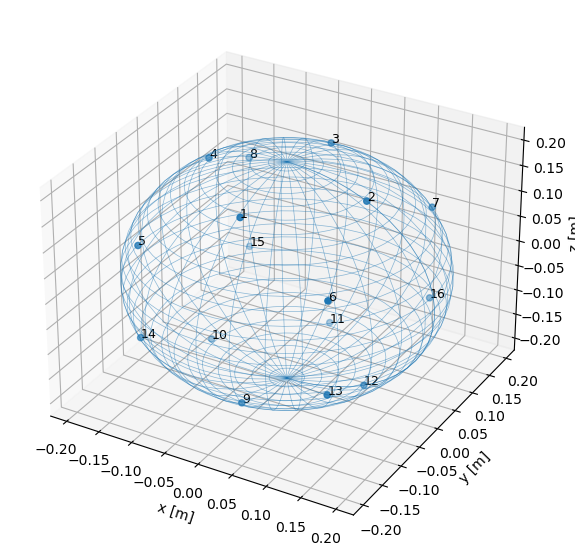

In [27]:
import numpy as np
import matplotlib.pyplot as plt

pts = np.asarray(PMT_COORDINATES)
x, y, z = pts[:, 0], pts[:, 1], pts[:, 2]

R = float(MODULE_RADIUS_M)  # 0.2159 gibi

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")

# PMT noktaları
ax.scatter(x, y, z)
for i, (xi, yi, zi) in enumerate(pts, start=1):
    ax.text(xi, yi, zi, str(i), fontsize=9)

# Küre (wireframe)
u = np.linspace(0, 2*np.pi, 60)
v = np.linspace(0, np.pi, 30)
xs = R * np.outer(np.cos(u), np.sin(v))
ys = R * np.outer(np.sin(u), np.sin(v))
zs = R * np.outer(np.ones_like(u), np.cos(v))
ax.plot_wireframe(xs, ys, zs, linewidth=0.5, alpha=0.5)

# Eksen/ölçek ayarı
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_zlabel("z [m]")

max_range = np.max([x.max()-x.min(), y.max()-y.min(), z.max()-z.min(), 2*R])
cx, cy, cz = x.mean(), y.mean(), z.mean()
half = max_range / 2
ax.set_xlim(cx - half, cx + half)
ax.set_ylim(cy - half, cy + half)
ax.set_zlim(cz - half, cz + half)

plt.show()


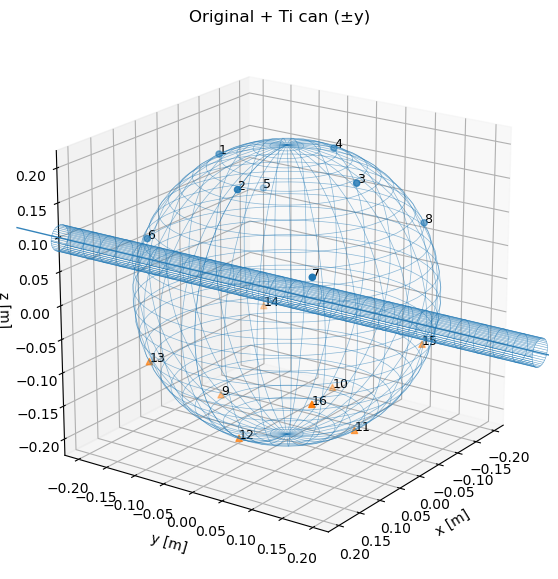

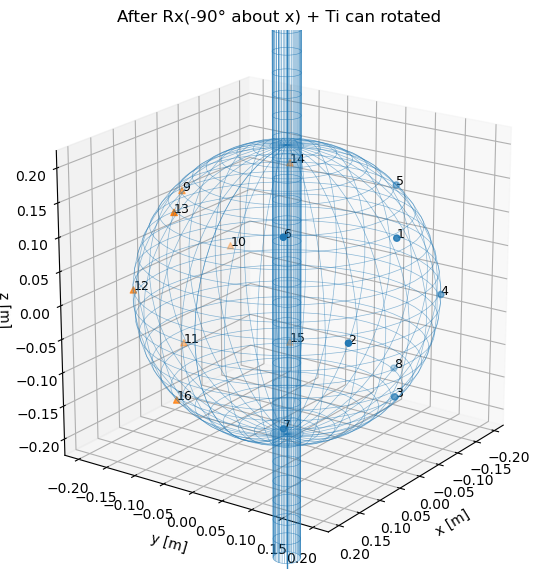

In [28]:
import numpy as np
import matplotlib.pyplot as plt

pts = np.asarray(PMT_COORDINATES, dtype=float)
R_sphere = float(MODULE_RADIUS_M)  # ör: 0.2159

TI_CAN_AXIS = np.array([0.0, 1.0, 0.0])
TI_CAN_RADIUS_M = 0.020  
TI_CAN_LENGTH_M = 0.820   

def Rx(deg):
    th = np.deg2rad(deg)
    c, s = np.cos(th), np.sin(th)
    return np.array([[1,0,0],[0,c,-s],[0,s,c]], dtype=float)

def make_cylinder(center, axis, radius, length, n_phi=72, n_z=28):
    center = np.asarray(center, float)
    axis = np.asarray(axis, float); axis /= np.linalg.norm(axis)
    ref = np.array([0,0,1.0]) if abs(axis[2]) < 0.9 else np.array([0,1.0,0])
    u = np.cross(axis, ref); u /= np.linalg.norm(u)
    v = np.cross(axis, u)

    phis = np.linspace(0, 2*np.pi, n_phi)
    zs = np.linspace(-length/2, length/2, n_z)
    cosphi = np.cos(phis)[:,None]; sinphi = np.sin(phis)[:,None]
    zz = zs[None,:]

    P = center[None,None,:] + axis[None,None,:] * zz[:,:,None]
    C = radius*(cosphi[:,:,None]*u[None,None,:] + sinphi[:,:,None]*v[None,None,:])
    S = P + C
    return S[:,:,0], S[:,:,1], S[:,:,2]

def plot_scene(ax, pts_in, tican_axis, title):
    x,y,z = pts_in[:,0], pts_in[:,1], pts_in[:,2]
    ax.set_title(title)

    ax.scatter(x[:8], y[:8], z[:8], marker="o")
    ax.scatter(x[8:], y[8:], z[8:], marker="^")
    for i,(xi,yi,zi) in enumerate(pts_in, start=1):
        ax.text(xi, yi, zi, str(i), fontsize=9)

    u = np.linspace(0, 2*np.pi, 60)
    v = np.linspace(0, np.pi, 30)
    xs = R_sphere*np.outer(np.cos(u), np.sin(v))
    ys = R_sphere*np.outer(np.sin(u), np.sin(v))
    zs = R_sphere*np.outer(np.ones_like(u), np.cos(v))
    ax.plot_wireframe(xs, ys, zs, linewidth=0.5, alpha=0.5)

    Xc,Yc,Zc = make_cylinder((0,0,0), tican_axis, TI_CAN_RADIUS_M, TI_CAN_LENGTH_M)
    ax.plot_wireframe(Xc, Yc, Zc, linewidth=0.4, alpha=0.7)

    a = np.asarray(tican_axis, float); a /= np.linalg.norm(a)
    p0 = -0.6*TI_CAN_LENGTH_M*a; p1 = 0.6*TI_CAN_LENGTH_M*a
    ax.plot([p0[0],p1[0]],[p0[1],p1[1]],[p0[2],p1[2]], linewidth=1.0, alpha=0.9)

    ax.set_xlim(-R_sphere, R_sphere)
    ax.set_ylim(-R_sphere, R_sphere)
    ax.set_zlim(-R_sphere, R_sphere)
    ax.set_box_aspect((1,1,1))
    ax.view_init(elev=20, azim=35)
    ax.set_xlabel("x [m]"); ax.set_ylabel("y [m]"); ax.set_zlabel("z [m]")

R = Rx(-90)

pts_rot = pts @ R.T
tican_axis_rot = R @ (TI_CAN_AXIS/np.linalg.norm(TI_CAN_AXIS))


fig1 = plt.figure(figsize=(7,7))
ax1 = fig1.add_subplot(111, projection="3d")
plot_scene(ax1, pts, TI_CAN_AXIS, "Original + Ti can (±y)")

fig2 = plt.figure(figsize=(7,7))
ax2 = fig2.add_subplot(111, projection="3d")
plot_scene(ax2, pts_rot, tican_axis_rot, "After Rx(-90° about x) + Ti can rotated")

plt.show()


In [29]:
R

array([[ 1.000000e+00,  0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  6.123234e-17,  1.000000e+00],
       [ 0.000000e+00, -1.000000e+00,  6.123234e-17]])

In [30]:
rotation_matrix_x_minus_90 = np.array([
    [1., 0., 0.],
    [0., 0., 1.],
    [0., -1., 0.]
])


In [31]:
# Understand:         
# pmts_hit  = np.where(np.logical_and(pmt_vector_distances < self.PMT_RADIUS_M, pmt_photon_angles >= 0))[0]
# this may help you to decife if you want to use the direction of PMT 

### Another PMT posn source:

In [32]:
import os
R = 0.21590  # DOMRadius [m]

fname = os.getenv("PONESRCDIR") + "/data/pmt_acc.npz"
data = np.load(fname)
pmt_coords = data["pmt_coords"]  # (16,3)

df_pmt = pd.DataFrame(pmt_coords, columns=["vx", "vy", "vz"])
df_pmt.insert(0, "pmt", np.arange(1, 17))

df_pmt["norm"] = np.sqrt(df_pmt["vx"]**2 + df_pmt["vy"]**2 + df_pmt["vz"]**2)

df_pmt["x"] = R * df_pmt["vx"]
df_pmt["y"] = R * df_pmt["vy"]
df_pmt["z"] = R * df_pmt["vz"]
df_pmt


,pmt,vx,vy,vz,norm,x,y,z
0,1,0.422618,0.000000e+00,-9.063078e-01,1.0,0.091243,0.000000e+00,-1.956719e-01
1,2,0.422618,9.063078e-01,-1.608123e-16,1.0,0.091243,1.956719e-01,-3.471937e-17
2,3,0.422618,1.109907e-16,9.063078e-01,1.0,0.091243,2.396289e-17,1.956719e-01
3,4,0.422618,-9.063078e-01,6.123234e-17,1.0,0.091243,-1.956719e-01,1.322006e-17
4,5,0.843391,3.799282e-01,-3.799282e-01,1.0,0.182088,8.202650e-02,-8.202650e-02
5,6,0.843391,3.799282e-01,3.799282e-01,1.0,0.182088,8.202650e-02,8.202650e-02
6,7,0.843391,-3.799282e-01,3.799282e-01,1.0,0.182088,-8.202650e-02,8.202650e-02
7,8,0.843391,-3.799282e-01,-3.799282e-01,1.0,0.182088,-8.202650e-02,-8.202650e-02
8,9,-0.422618,9.063078e-01,-1.608123e-16,1.0,-0.091243,1.956719e-01,-3.471937e-17
9,10,-0.422618,5.175581e-17,-9.063078e-01,1.0,-0.091243,1.117408e-17,-1.956719e-01
